In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import requests
import shutil
from textwrap import wrap

In [176]:
def retrieve_entry(pdb_id):

    url = 'https://www.ebi.ac.uk/pdbe/static/entry/' + \
    pdb_id.lower() + \
    '_assembly_1_chain_front_image-800x800.png'

    url = 'https://cdn.rcsb.org/images/structures/' + pdb_id.lower() + '_assembly-1.jpeg'
    filename = '../img/' + pdb_id.lower() + '.jpg'

    r = requests.get(url, stream = True)

    if r.status_code == 200:
        with open(filename,'wb') as f:
            shutil.copyfileobj(r.raw, f)
    else:
        print('Image Couldn\'t be retrieved')
    
    return filename

In [2]:
gene2lit = pd.read_csv('../data/pubtator_title_or_abstract_in_any_gene2pubmed_paper_no_reviews.csv')

In [3]:
gene_info = pd.read_csv('../data/gene_info_221228.csv')

In [9]:
genes = np.unique(gene_info['gene_ncbi'])

In [238]:
gene_otd = np.random.choice(genes)

In [239]:
gene_slice = gene_info[gene_info['gene_ncbi'] == gene_otd]

In [240]:
gene_symbol = gene_slice['symbol_ncbi'].values[0]
gene_name = gene_slice['description'].values[0]
gene_type = gene_slice['type_of_gene'].values[0]

In [241]:
pdb_id = gene_slice['pdb_id'].values[0]
structure_title = gene_slice['structure_title'].values[0]

In [242]:
has_pdb =  type(pdb_id) == str

In [243]:
gene2lit_slice = gene2lit[gene2lit['gene_ncbi'] == gene_otd]

In [244]:
has_pubs = len(gene2lit_slice) > 0

In [245]:
groupby_year = gene2lit_slice.groupby('year').count().reindex(range(1950,2021)).fillna(0.0)['pubmed_id']

In [246]:
has_pubs, has_pdb

(False, False)

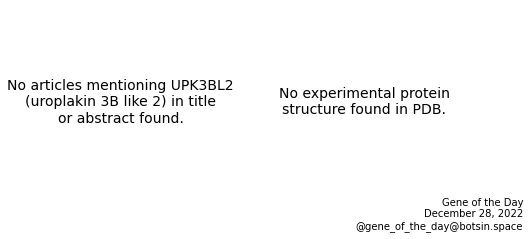

In [249]:
fig, axes = plt.subplots(figsize=(8,3.5), nrows=1, ncols=2, gridspec_kw={'width_ratios':[1,1]})

if has_pubs:
    axes[0].bar(height=groupby_year, x=groupby_year.index)
    min_year = gene2lit_slice['year'].min() - 2
    min_year = np.min([min_year, 2009])
    axes[0].set_xlim([min_year, 2021])
    axes[0].tick_params(labelsize=14, axis='both', width=1.5)
    axes[0].set_xlabel('year', fontsize=14)
    axes[0].set_ylabel('number of articles\nfeaturing gene', fontsize=14)
    axes[0].set_ylabel('number of articles\nfeaturing gene', fontsize=14)

    title_str = gene_symbol + ' (' + gene_name + ')'
    title_str = '\n'.join(wrap(title_str, width=30))
    axes[0].set_title(title_str, x=0, y=1.05, ha='left', fontsize=14)

    axes[0].spines['right'].set_visible(False)
    axes[0].spines['top'].set_visible(False)
    [axes[0].spines[i].set_linewidth(2) for i in axes[0].spines]
else:
    axes[0].axis(False)
    except_str = 'No articles mentioning ' + gene_symbol + \
    ' (' + gene_name + ')'+ ' in title or abstract found.'
    axes[0].text(s='\n'.join(wrap(except_str, width=30)), y=0.5, x=0.5, 
                 ha='center', fontsize=14, va='center')


if has_pdb:
    filename = retrieve_entry(pdb_id)
    img = mpl.image.imread(filename)
    axes[1].imshow(img)
    axes[1].axis(False)
    title_str = pdb_id + ': ' + structure_title
    axes[1].set_title('\n'.join(wrap(title_str, width=30)), fontsize=14, va='bottom', ha='left', x=0, y=1.05)
else:
    axes[1].axis(False)
    except_str = 'No experimental protein structure found in PDB'
    if gene_type != 'protein-coding':
        except_str = except_str + ' (gene is probably not protein-coding).'
    else:
        except_str = except_str + '.'
    axes[1].text(s='\n'.join(wrap(except_str, width=30)), y=0.5, x=0.5, 
                 ha='center', fontsize=14, va='center')

# Signature
today = datetime.date.today()
today_str = today.strftime("%B %d, %Y")
fig.text(s='Gene of the Day\n' + today_str + '\n@gene_of_the_day@botsin.space', x=1,y=0, ha='right')

plt.savefig('../img/' + str(gene_otd) + '.png', dpi=200, bbox_inches='tight', facecolor='white', transparent=False)

In [180]:
gene_info['type_of_gene'].value_counts()

protein-coding    80596
pseudo             9164
ncRNA              6435
snoRNA              730
other               368
snRNA                83
rRNA                 20
scRNA                 4
unknown               1
Name: type_of_gene, dtype: int64

In [25]:
from mastodon import Mastodon

In [174]:
mastodon = Mastodon(
    access_token = '../token.secret',
    api_base_url = 'https://botsin.space/'
)

In [175]:
media = mastodon.media_post('../img/' + str(gene_otd) + '.png')
status = mastodon.status_post("test: " + str(gene_otd) + '\nThis gene is PTPA.', media_ids=media)

gene_ncbi
2            13
9             2
10            1
12           24
16            6
             ..
102800317     2
104909134     4
109703458     1
110599564     1
111188157     1
Name: pdb_id, Length: 6345, dtype: int64

In [91]:
np.random.choice(gene_info['pdb_id'].dropna())

'5PUA'

In [153]:
import datetime

In [157]:
today = datetime.date.today()
today.strftime("%B %d, %Y")

'December 28, 2022'

In [163]:
gene_info['in_gene2lit'] = gene_info['gene_ncbi'].isin(gene2lit['gene_ncbi'])

In [166]:
gene_info.dropna(subset=['pdb_id'])['in_gene2lit'].sum()

52243

In [172]:
gene_info[~gene_info['pdb_id'].isna() | gene_info['in_gene2lit']]['gene_ncbi'].value_counts()

760          1010
23476         492
2147          440
23621         435
1017          434
             ... 
57730           1
6157            1
6159            1
6160            1
115072896       1
Name: gene_ncbi, Length: 16625, dtype: int64

In [173]:
16625 * 300

4987500